In [14]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


import sys
sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from baseline.immnue_score import immnue_score_methods
from conceptor.utils import plot_embed_with_label,plot_performance, score


def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

loo = LeaveOneOut()

In [15]:
import sys
sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from baseline.immnue_score import immnue_score_methods
from conceptor.utils import plot_embed_with_label,plot_performance, score

In [16]:
data_path = '../paper/00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))
df_tpm.shape, df_label.shape

((1133, 15672), (1133, 111))

In [17]:
df_task = onehot(df_label.response_label)
size = df_label.groupby('cohort').size()
size = size.index + "\n(n = " + size.astype(str) + ")"
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()
cohorts = ['Gide']

In [18]:
## for TIDE input
cohort_cancer_map = {'Allen': 'SKCM','Choueiri': 'KIRC', 'Gide': 'SKCM', 'Hugo': 'SKCM',
                     'IMVigor210': 'BLCA', 'IMmotion150': 'KIRC', 'Kim': 'STAD',
                     'Liu': 'SKCM', 'MGH': 'SKCM', 'Miao': 'KIRC', 'Riaz': 'SKCM', 
                     'Rose': 'BLCA', 'SU2CLC1': 'LUAD', 'SU2CLC2': 'LUSC',
                     'Snyder': 'BLCA', 'Zhao': 'GBM'}

## for NetBio input
cohort_target_map = {'Allen': 'CTLA4','Choueiri': 'PD1', 'Gide': 'PD1_CTLA4',
                     'Hugo': 'PD1', 'IMVigor210': 'PDL1', 'IMmotion150': 'PDL1',
                     'Kim': 'PD1', 'Liu': 'PD1', 'MGH':  'PD1_CTLA4',
                     'Miao': 'PD1_PDL1_CTLA4', 'Riaz': 'PD1', 'Rose': 'PD1_PDL1_CTLA4',
                     'SU2CLC1': 'PD1', 'SU2CLC2': 'PD1_PDL1_CTLA4',
                     'Snyder': 'PDL1', 'Zhao': 'PD1'}

100%|##########| 73/73 [01:30<00:00,  1.25s/it]


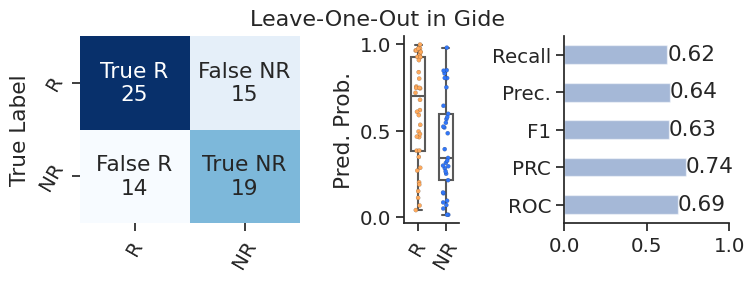

In [19]:
mode = 'NetBio'

work_dir = './tmpignore/LOO_%s_test' % (mode)
if not os.path.exists(work_dir):
    os.makedirs(work_dir)

res = []
for cohort in cohorts:
    
    ## Get data for this cohort
    cohort_idx = df_label[df_label['cohort'] == cohort].index
    cohort_X = df_tpm.loc[cohort_idx]
    cohort_y = df_task.loc[cohort_idx]
    
    ## Get features for specific method
    cohort_target = cohort_target_map[cohort]
    cohort_cancer_type = cohort_cancer_map[cohort]
    Extractor = immnue_score_methods[mode]
    E = Extractor(cancer_type=cohort_cancer_type, drug_target=cohort_target)
    cohort_dfx = E(cohort_X)
    cohort_dfy = cohort_y['R']
    

    ## Leave-out-out validation
    predict_res = []
    for train_idx, test_idx in tqdm(list(loo.split(cohort_idx)), ascii=True):
        
        train_X = cohort_dfx.iloc[train_idx]
        train_y = cohort_dfy.iloc[train_idx]
        test_X = cohort_dfx.iloc[test_idx]    
        test_y = cohort_dfy.iloc[test_idx]
    
        ## Z-score scale fitting on the training set, and transform on test data
        data_scaler = StandardScaler()
        train_X = data_scaler.fit_transform(train_X)
        test_X = data_scaler.transform(test_X)
    
        param_grid = {'penalty':['l2'], 'max_iter':[int(1e10)], 'solver':['lbfgs'],
                      'C':np.arange(0.1, 1, 0.1), 'class_weight':['balanced'] }
        model = LogisticRegression()
        
        gcv = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1).fit(train_X, train_y)
        best_C = gcv.best_params_['C']
        
        pred_prob = gcv.best_estimator_.predict_proba(test_X)
    
        pred_testy = pd.DataFrame(pred_prob)
        pred_testy['best_C'] = best_C
        pred_testy['cohort'] = cohort    
        pred_testy['mode'] = mode
        predict_res.append(pred_testy)

    df_pred = pd.concat(predict_res)
    df_pred.index = cohort_y.index
    
    dfp = cohort_y.join(df_pred)
    dfp.to_csv(os.path.join(work_dir, '%s.csv' % cohort ))
    
    y_true, y_prob, y_pred = dfp['R'], dfp[1], dfp[[0, 1]].idxmax(axis=1)
    s2 = score(y_true, y_prob, y_pred)
    dfs = pd.DataFrame([s2], columns = ['ROC', 'PRC', 'F1', 'ACC'], index = ['Test'])
    dfs['cohort'] = cohort
    dfs['mode'] = mode
    dfs['seed'] = np.nan
    
    fig = plot_performance(y_true, y_prob, y_pred)
    fig.suptitle('Leave-One-Out in %s' % cohort, fontsize=16)
    fig.savefig(os.path.join(work_dir, 'leave_one_out_%s.jpg' % cohort))

    res.append(dfs)

dfres = pd.concat(res) #.reset_index(drop=True)
dfres.to_csv(os.path.join(work_dir, 'performance.tsv'), sep='\t')

In [20]:
immnue_score_methods

{'PD1': baseline.immnue_score.PD1.PD1,
 'PDL1': baseline.immnue_score.PDL1.PDL1,
 'CTLA4': baseline.immnue_score.CTLA4.CTLA4,
 'CD8': baseline.immnue_score.CD8.CD8,
 'GeneBio': baseline.immnue_score.GeneBio.GeneBio,
 'NetBio': baseline.immnue_score.Kong_NetBio.Kong_NetBio,
 'MIAS': baseline.immnue_score.Wu_MIAS.Wu_MIAS,
 'GEP': baseline.immnue_score.Cristescu_GEP.Cristescu_GEP,
 'IMPRES': baseline.immnue_score.Auslander_IMPRES.Auslander_IMPRES,
 'TIDE': baseline.immnue_score.Jiang_TIDE.Jiang_TIDE,
 'NRS': baseline.immnue_score.Huang_NRS.Huang_NRS,
 'IFNG': baseline.immnue_score.Ayers_IFNG.Ayers_IFNG,
 'CIS': baseline.immnue_score.Davoli_CIS.Davoli_CIS,
 'IS': baseline.immnue_score.Roh_IS.Roh_IS,
 'Teff': baseline.immnue_score.Fehrenbacher_Teff.Fehrenbacher_Teff,
 'PGM': baseline.immnue_score.Freeman_PGM.Freeman_PGM,
 'CKS': baseline.immnue_score.Messina_CKS.Messina_CKS,
 'CAF': baseline.immnue_score.Nurmik_CAFs.Nurmik_CAFs,
 'CTL': baseline.immnue_score.Jiang_CTLs.Jiang_CTLs,
 'TAM': b